# Дебайеризация (demosaicing) байеровского изображения

## 1. Дебайеризация изображения 

### 1.1. Задача: 

Из изображения Байера восстановить RGB-изображение.

![](figures/Debayering.png)

Шаблон Байера - это массив цветных фильтров (CFA), используемый в цифровых камерах. Он представляет собой шаблон из цветных фильтров, расположенных над пикселями цифрового датчика изображения. Шаблон используется для разделения изображения на цветовые компоненты и восстановления полноцветного изображения. Шаблон Байера назван в честь немецкого физика Фридриха Байера, который изобрел его в 1976 году.

![](figures/patterns.png)

### 1.2. Метрики:

Для оценки качества реконструкции используется метрика отношения пикового сигнала к шуму (PSNR). PSNR определяется как:

$$PSNR = 10 \log_{10} \left( \frac{MAX^2}{MSE} \right)$$

где $MAX$ - максимальное значение изображения (255 для 8-битных изображений), а $MSE$ - средняя квадратичная ошибка (MSE) между исходным и восстановленным изображением.

Другой метрикой, используемой для оценки качества реконструкции, является индекс структурного сходства (SSIM). SSIM определяется как:

$$SSIM = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

где $\mu_x$ и $\mu_y$ - средние значения исходного и реконструированного изображения соответственно, $\sigma_x^2$ и $\sigma_y^2$ - дисперсии исходного и реконструированного изображения соответственно, $\sigma_{xy}$ - ковариация исходного и реконструированного изображения, а $C_1$ и $C_2$ - две константы, которые используются для стабилизации деления на ноль.

PSNR отвечает за восстановление интенсивности изображения, а SSIM - за восстановление структуры изображения.

Эти метрики реализованы в пакете [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/).

/Users/gosha20777/miniconda3/envs/cst/lib/python3.12/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


PSNR 26.9716
SSIM 0.842611
SSIM (flip) 0.210347


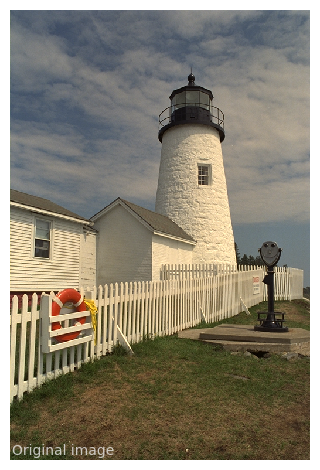

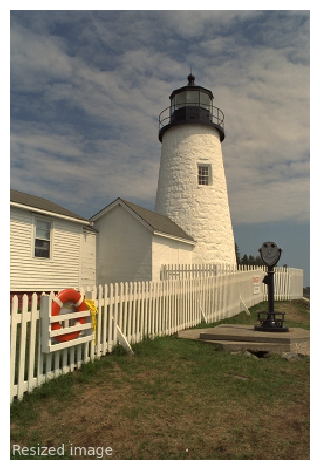

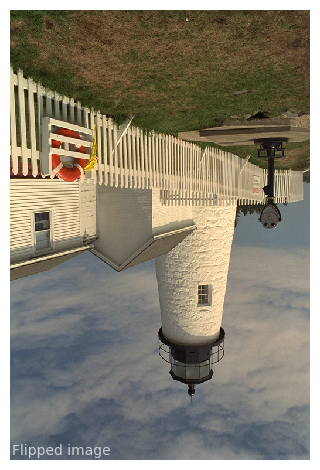

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [2]:
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
import tensorflow as tf
import colour
import cv2

# PSNR metric example

image = colour.io.read_image('data/Lighthouse.png')
resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
resized_image = cv2.resize(resized_image, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_AREA)

psnr = tf.image.psnr(image, resized_image, max_val=1.0)
print('PSNR', psnr.numpy())

# SSIM metric example
ssim = tf.image.ssim(image, resized_image, max_val=1.0)
print('SSIM', ssim.numpy())

flip_image = cv2.flip(image, 0)

ssim = tf.image.ssim(image, flip_image, max_val=1.0)
print('SSIM (flip)', ssim.numpy())

colour.plotting.plot_image(
    image, 
    text_kwargs={'text': 'Original image'}
    )
colour.plotting.plot_image(
    resized_image,
    text_kwargs={'text': 'Resized image'}
    )
colour.plotting.plot_image(
    flip_image,
    text_kwargs={'text': 'Flipped image'}
    )

## Набор данных:

В этом блокноте используется набор данных [MSR Demosaicing Dataset](https://www.microsoft.com/en-us/download/confirmation.aspx?id=52535). 

Набор данных Microsoft Research Cambridge Demosaicing состоит из набора необработанных изображений и их уменьшенных версий, которые могут быть использованы для обучения и оценки демозаики (и, возможно, других задач, таких как денуазинг), как в линейном пространстве, так и в цветовом пространстве.

Необработанные изображения получены двумя разными камерами: 
- Panasonic Lumix DMC-LX3
- Canon EOS 550D


RGB-изображения были получены путем суперпиксельной интерполяции необработанных изображений.
Необработанные изображения были получены путем понижения дискретизации изображений в 2 раза.

### Демозаика суперпикселей

G = (G1 + G1) / 2
R = R
B = B

![](figures/superpixel.png)

### Downsampling

![](figures/downsampling.png)


- https://danielkhashabi.com/files/2013_2014_demosaicing/2014_RTF_demosaicing.pdf

In [3]:
import colour
import matplotlib.pyplot as plt
import debayering
from debayering import mosaicing

/Users/gosha20777/miniconda3/envs/cst/lib/python3.12/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


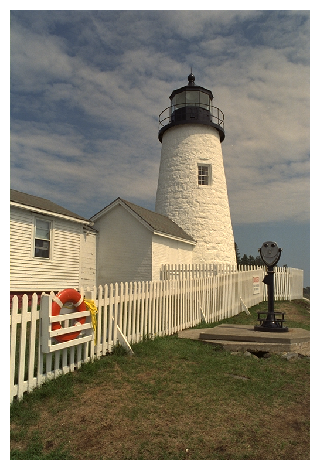

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [4]:
image = colour.io.read_image('data/Lighthouse.png')
colour.plotting.plot_image(image)

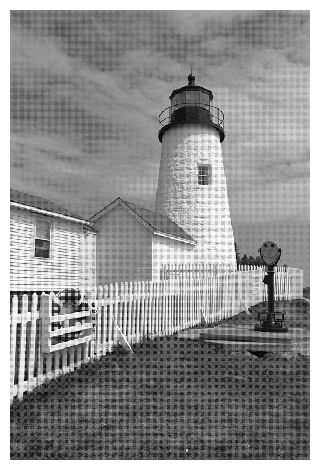

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [5]:
bayer = mosaicing.rgb2bayer(image, pattern="BGGR")
colour.plotting.plot_image(bayer)

## Билинейная демозаика

Билинейная демозаицика - это метод, используемый в цифровой обработке изображений для восстановления полноцветного изображения из мозаики Байера. Метод использует простой алгоритм линейной интерполяции, который берет среднее значение цвета соседних пикселей для оценки недостающих значений цвета. В результате получается полноцветное изображение с уменьшенными цветовыми артефактами и улучшенным разрешением по сравнению с исходным мозаичным изображением Байера.

![](figures/bilinear.png)

Этот метод прост в реализации и эффективен с точки зрения вычислений, но он может привести к заметным цветовым артефактам и недостатку деталей в результирующем изображении по сравнению с более продвинутыми методами демозаики.

![](figures/issues.png)


### Реализация

С использованием сверток:

![](figures/conv_imp.png)

- https://hal.science/hal-00683233/document
- https://www.researchgate.net/figure/Example-of-a-bilinear-interpolation-computed-with-convolution-filters-Left-the-original_fig1_37414255

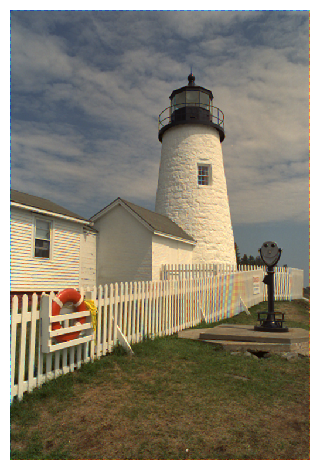

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [6]:
from debayering import bileniar
rgb = bileniar.bayer2rgb(bayer, pattern="BGGR")
colour.plotting.plot_image(rgb)

### Алгоритм демозаики Malvar (2004)

- http://www.ipol.im/pub/art/2011/g_mhcd/

Это более продвинутый алгоритм демозаицирования по сравнению с Bilinear Demosaicing, и он известен тем, что позволяет получать высококачественные изображения с уменьшенными цветовыми артефактами и повышенной детализацией.

![](figures/malvar.png)

В основе алгоритма Malvar Demosaicing лежит идея оценки недостающей цветовой информации для каждого пикселя на основе градиента цветовой информации окружающих его пикселей. Алгоритм использует ряд математических преобразований и фильтров для вычисления градиента цветовой информации и получения полноцветного изображения.

Чтобы улучшить качество билинейного метода, Малвар, Хе и Катлер, следуя работе Пея и Тама, добавляют кросс-канальные поправки Лапласа. Зеленая компонента в месте расположения красного пикселя оценивается как

![](figures/malvar1.png)
![](figures/malvar2.png)
![](figures/malvar3.png)


Одной из ключевых особенностей алгоритма Malvar Demosaicing является то, что он учитывает пространственное частотное содержание изображения, то есть различает высокочастотные и низкочастотные детали на изображении. Это позволяет алгоритму лучше сохранять мелкие детали и края изображения, уменьшая при этом цветовые артефакты.

![](figures/malvar4.png)

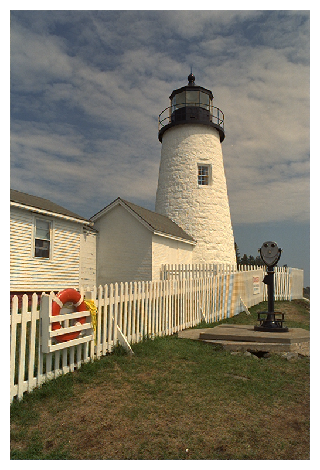

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [7]:
from debayering import malvar
rgb = malvar.bayer2rgb(bayer, pattern="BGGR")
colour.plotting.plot_image(rgb)

### Menon (2007) алгоритм демозаики

- http://elynxsdk.free.fr/ext-docs/Demosaicing/todo/Menon_Andriani_IEEE_T_IP_2007.pdf

Алгоритм демозаики Menon (2007) - это современный метод для преобразования изображения с паттерном Байера в полноцветное изображение. В основе этого алгоритма лежит пространственно-адаптивный метод цветовой интерполяции, учитывающий пространственную изменчивость цветовой информации в изображении.

Алгоритм демозаикации Менона (2007) начинает работу с вычисления градиента информации о цветности для каждого пикселя изображения с шаблоном Байера. На основе этой информации алгоритм определяет пиксели с высокими значениями градиента и присваивает им большой вес в процессе интерполяции. Этот вес помогает сохранить резкость и детализацию изображения, одновременно сглаживая шумы и артефакты.

Первым шагом алгоритма является восстановление зеленого
изображения по горизонтали и вертикали. Для интерполяции
образцов Байера мы применяем пятикоэффициентный FIR-фильтр.

![](figures/menon1.png)

```python
G_H = np.where(G_m == 0, _cnv_h(CFA, h_0) + _cnv_h(CFA, h_1), G)
G_V = np.where(G_m == 0, _cnv_v(CFA, h_0) + _cnv_v(CFA, h_1), G)
```

![](figures/menon2.png)

После интерполяции зеленой составляющей в обоих
горизонтальном и вертикальном направлениях и получения двух зеленых изображений, необходимо принять решение о выборе направления фильтрации, которое дает наилучшую производительность. На самом деле, цвета
медленно изменяются и претерпевают резкие изменения только по
по краям. Поэтому изображение обычно имеет большие значения
градиентов цветовых различий по краям, чем вдоль них.

![](figures/menon3.png)


Далее вычисляем градиенты цветности, точнее, горизонтальный и вертикальный градиент.

![](figures/menon4.png)
![](figures/menon5.png)

Далее алгоритм использует направленную фильтрацию для оценки недостающей цветовой информации для каждого пикселя на основе окружающих его пикселей. Коэффициенты фильтра выбираются на основе информации о градиенте, чтобы интерполяция была оптимизирована для конкретного изображения.

![](figures/menon6.png)

Наконец, алгоритм выполняет шаг пространственного уточнения, который корректирует оценочную цветовую информацию на основе согласованности цветовой информации в окружающей области. Этот шаг помогает уменьшить цветовые артефакты и улучшить общее качество результирующего изображения.

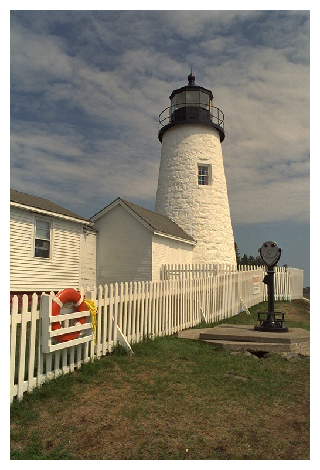

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [8]:
from debayering import menon

rgb = menon.bayer2rgb(bayer, pattern="BGGR")
colour.plotting.plot_image(rgb)

/Users/gosha20777/miniconda3/envs/cst/lib/python3.12/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


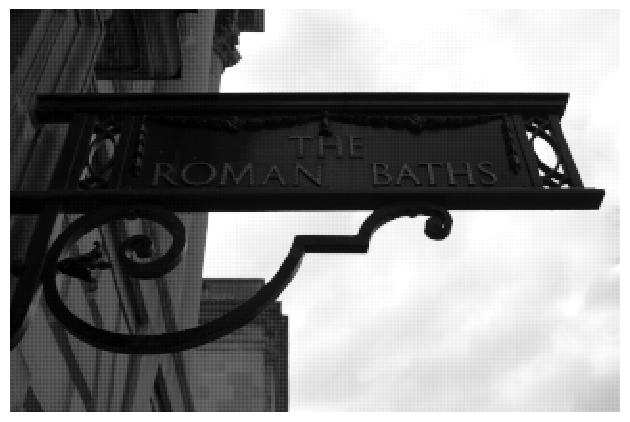

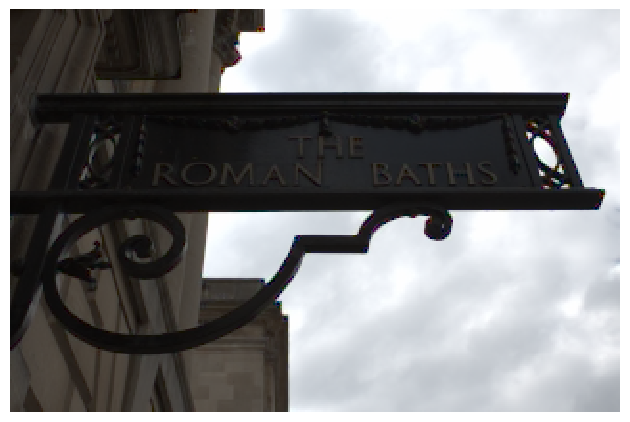

/Users/gosha20777/miniconda3/envs/cst/lib/python3.12/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


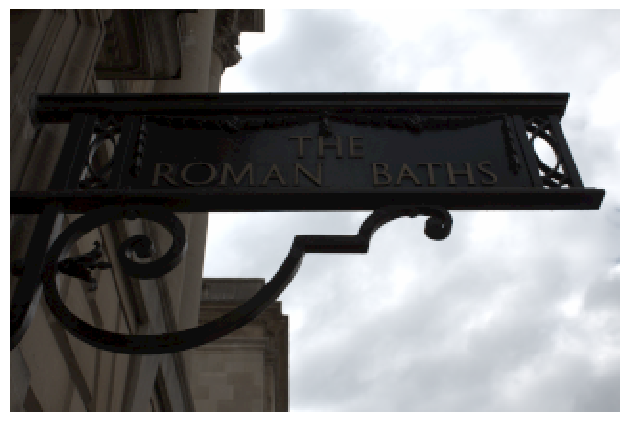

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [10]:
raw = colour.io.read_image('data/debayer/input/1.png')
colour.plotting.plot_image(colour.cctf_encoding(raw))
rgb = menon.bayer2rgb(raw, pattern="RGGB")
colour.plotting.plot_image(colour.cctf_encoding(rgb))
gt = colour.io.read_image('data/debayer/groundtruth/1.png')[:,:,:3]
colour.plotting.plot_image(colour.cctf_encoding(gt))

In [11]:
from debayering.utils import evaluate

psnr, ssim = evaluate(bileniar, "data/debayer")

print('Bileniar')
print("PSNR: ", psnr)
print("SSIM: ", ssim)

psnr, ssim = evaluate(malvar, "data/debayer")

print('Malvar')
print("PSNR: ", psnr)
print("SSIM: ", ssim)

psnr, ssim = evaluate(menon, "data/debayer")

print('Мenon')
print("PSNR: ", psnr)
print("SSIM: ", ssim)

/Users/gosha20777/miniconda3/envs/cst/lib/python3.12/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)  # noqa: B028


Bileniar
PSNR:  31.4404258393
SSIM:  0.931879262129
Malvar
PSNR:  37.2042555223
SSIM:  0.973826715821
Мenon
PSNR:  39.7011094344
SSIM:  0.981253005956


## Deep Demosaicing

https://arxiv.org/pdf/1802.03769.pdf

![](figures/deep.png)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import colour
import matplotlib.pyplot as plt

import random

In [2]:
from debayering.datasets.raw_dataset import RawLoader

raw_shape = colour.io.read_image('data/debayer/input/1.png').shape
raw_shape = (int(raw_shape[0] / 2), int(raw_shape[1] / 2))

print(raw_shape)

base_dir = "data/debayer"
train_input_dir = os.path.join(base_dir, "input")
train_target_dir = os.path.join(base_dir, "groundtruth")
img_size = raw_shape
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 8
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = RawLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = RawLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_gen))
print("Number val batches:", len(val_gen))

(105, 159)
1.png | 1.png
10.png | 10.png
11.png | 11.png
12.png | 12.png
13.png | 13.png
14.png | 14.png
15.png | 15.png
16.png | 16.png
17.png | 17.png
18.png | 18.png
Number of samples: 57
Number train batches: 6
Number val batches: 1


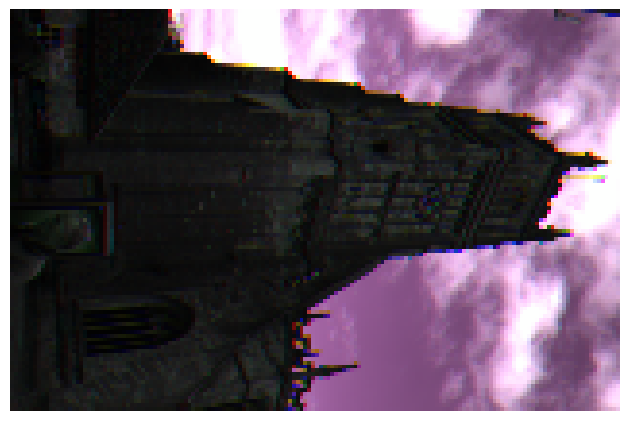

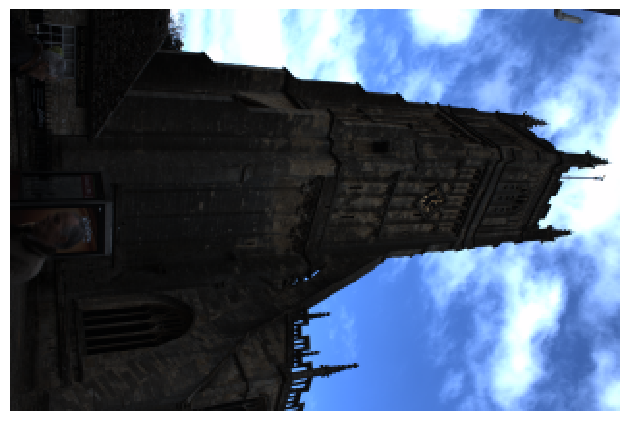

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [3]:
x, y = train_gen.__getitem__(0)
colour.plotting.plot_image(x[0][:,:,1:4])
colour.plotting.plot_image(y[0])

In [4]:
def main_loss(y_true, y_pred):
    return tf.abs(y_true - y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [5]:
from debayering.models import simple_conv

simple_conv_model = simple_conv.get_model()
simple_conv_model.compile(optimizer='adam', loss=main_loss, metrics=[ssim, psnr])
simple_conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 16) │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 16) │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 12) │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, None, 3)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,652 (18.17 KB)

 Trainable params: 4,652 (18.17 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
epochs = 100

history = simple_conv_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen,
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - loss: 0.1288 - psnr: 14.6332 - ssim: 0.2499 - val_loss: 0.1068 - val_psnr: 16.3458 - val_ssim: 0.3489
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - loss: 0.0907 - psnr: 16.7650 - ssim: 0.3486 - val_loss: 0.0739 - val_psnr: 18.7971 - val_ssim: 0.4099
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - loss: 0.0684 - psnr: 18.8937 - ssim: 0.4072 - val_loss: 0.0539 - val_psnr: 21.4225 - val_ssim: 0.5483
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - loss: 0.0576 - psnr: 20.3956 - ssim: 0.5111 - val_loss: 0.0398 - val_psnr: 24.0635 - val_ssim: 0.6637
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - loss: 0.0426 - psnr: 23.2010 - ssim: 0.6136 - val_loss: 0.0332 - val_psnr: 25.1860 - val_ssim: 0.6997
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 0.0393 - psnr: 23.7471 - ssim: 0.6469 - val_loss: 0.0337 - val_psnr: 25.1369 - val_ssim: 0.6773
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - loss: 0.0371 - ps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0148 - psnr: 33.2169 - ssim: 0.9524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


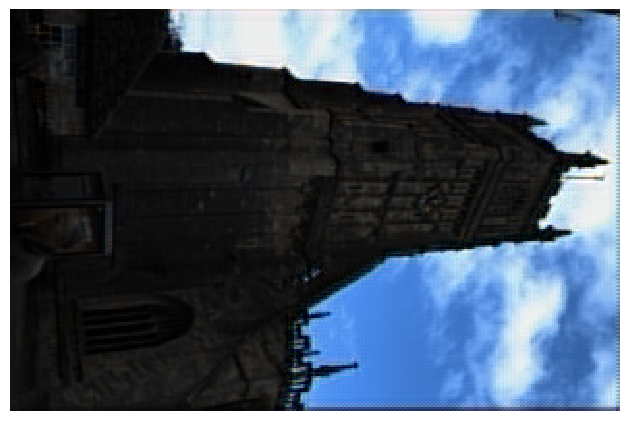

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [8]:
simple_conv_model.evaluate(val_gen)
pred = simple_conv_model.predict(x)
colour.plotting.plot_image(pred[0])

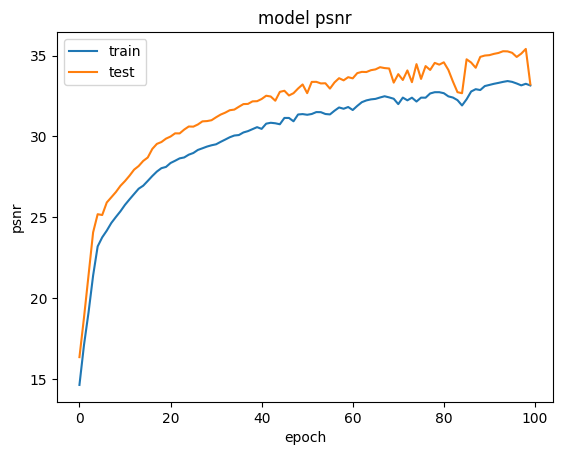

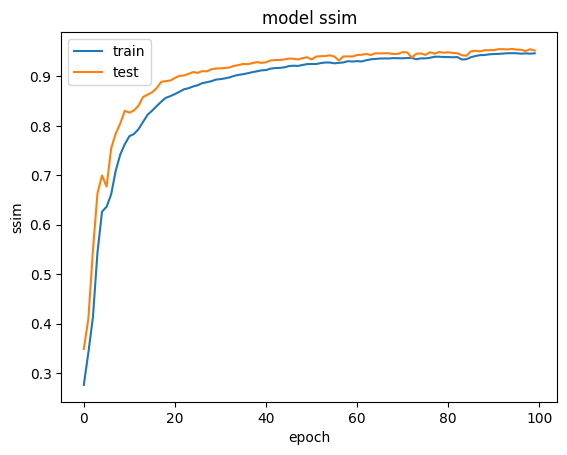

In [9]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Results

*Bileniar*

- PSNR:  31.4404257724
- SSIM:  0.931879263175

*Malvar*

- PSNR:  32.391568235
- SSIM:  0.939189145647

*Мenon*

- PSNR:  33.1207515124
- SSIM:  0.941916714245

*Deep Learning*

- PSNR:  35.1028
- SSIM:  0.9623

## Conclusion

The best results were obtained using the deep learning method. The results of the other methods are not bad, but the deep learning method is better.


## Extra links
- http://www.ok.sc.e.titech.ac.jp/res/DM/RI.pdf